<a href="https://colab.research.google.com/github/nathsmo/Victimas_PNC_2017/blob/master/Evaluacion_de_datos_en_agrupacion_de_los_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Data Processing  & Modeling </center>
## <center> Nathalia Morales </center>
### <center> Proyecto final Elements of Machine Learning </center>
### <center> UFM 2019 </center>



# Pre-procesamiento

### Importando las librerías necesarias

In [0]:
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.externals.six import StringIO  
from sklearn import metrics
import pandas as pd
import numpy as np  
import pydotplus
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import cross_val_score
from pandas import DataFrame
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
import sklearn
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

### Código para importar el archivo desde Colaboratory

In [0]:
from google.colab import files
uploaded = files.upload()

### Código para leer el csv desde el folder local o ya subido a Colaboratory

In [0]:
df = pd.read_csv('vic_final.csv')
df.drop(u'Unnamed: 0', axis=1, inplace=True)# irrelevante

### Vista general previa

In [0]:
# Forma de la data
df.shape

(32257, 14)

In [0]:
df.head()

,mes,dia,dia_sem,hora,g_hora,area,dept,muni,sexo,edad,g_edad,mayor_menor,delito,g_delitos
0,1,1,7,3,1,2,1,115,1,22,5,1,69,4
1,1,1,7,19,4,2,2,207,1,24,5,1,69,4
2,1,2,1,8,2,2,19,1901,1,35,8,1,75,3
3,1,2,1,18,4,1,5,501,1,27,6,1,75,3
4,1,2,1,12,3,2,10,1001,1,62,13,1,75,3


### Observaciones generalizadas de la data (Usando Seaborn Pairplot) del dataset general

/usr/local/lib/python2.7/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python2.7/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python2.7/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


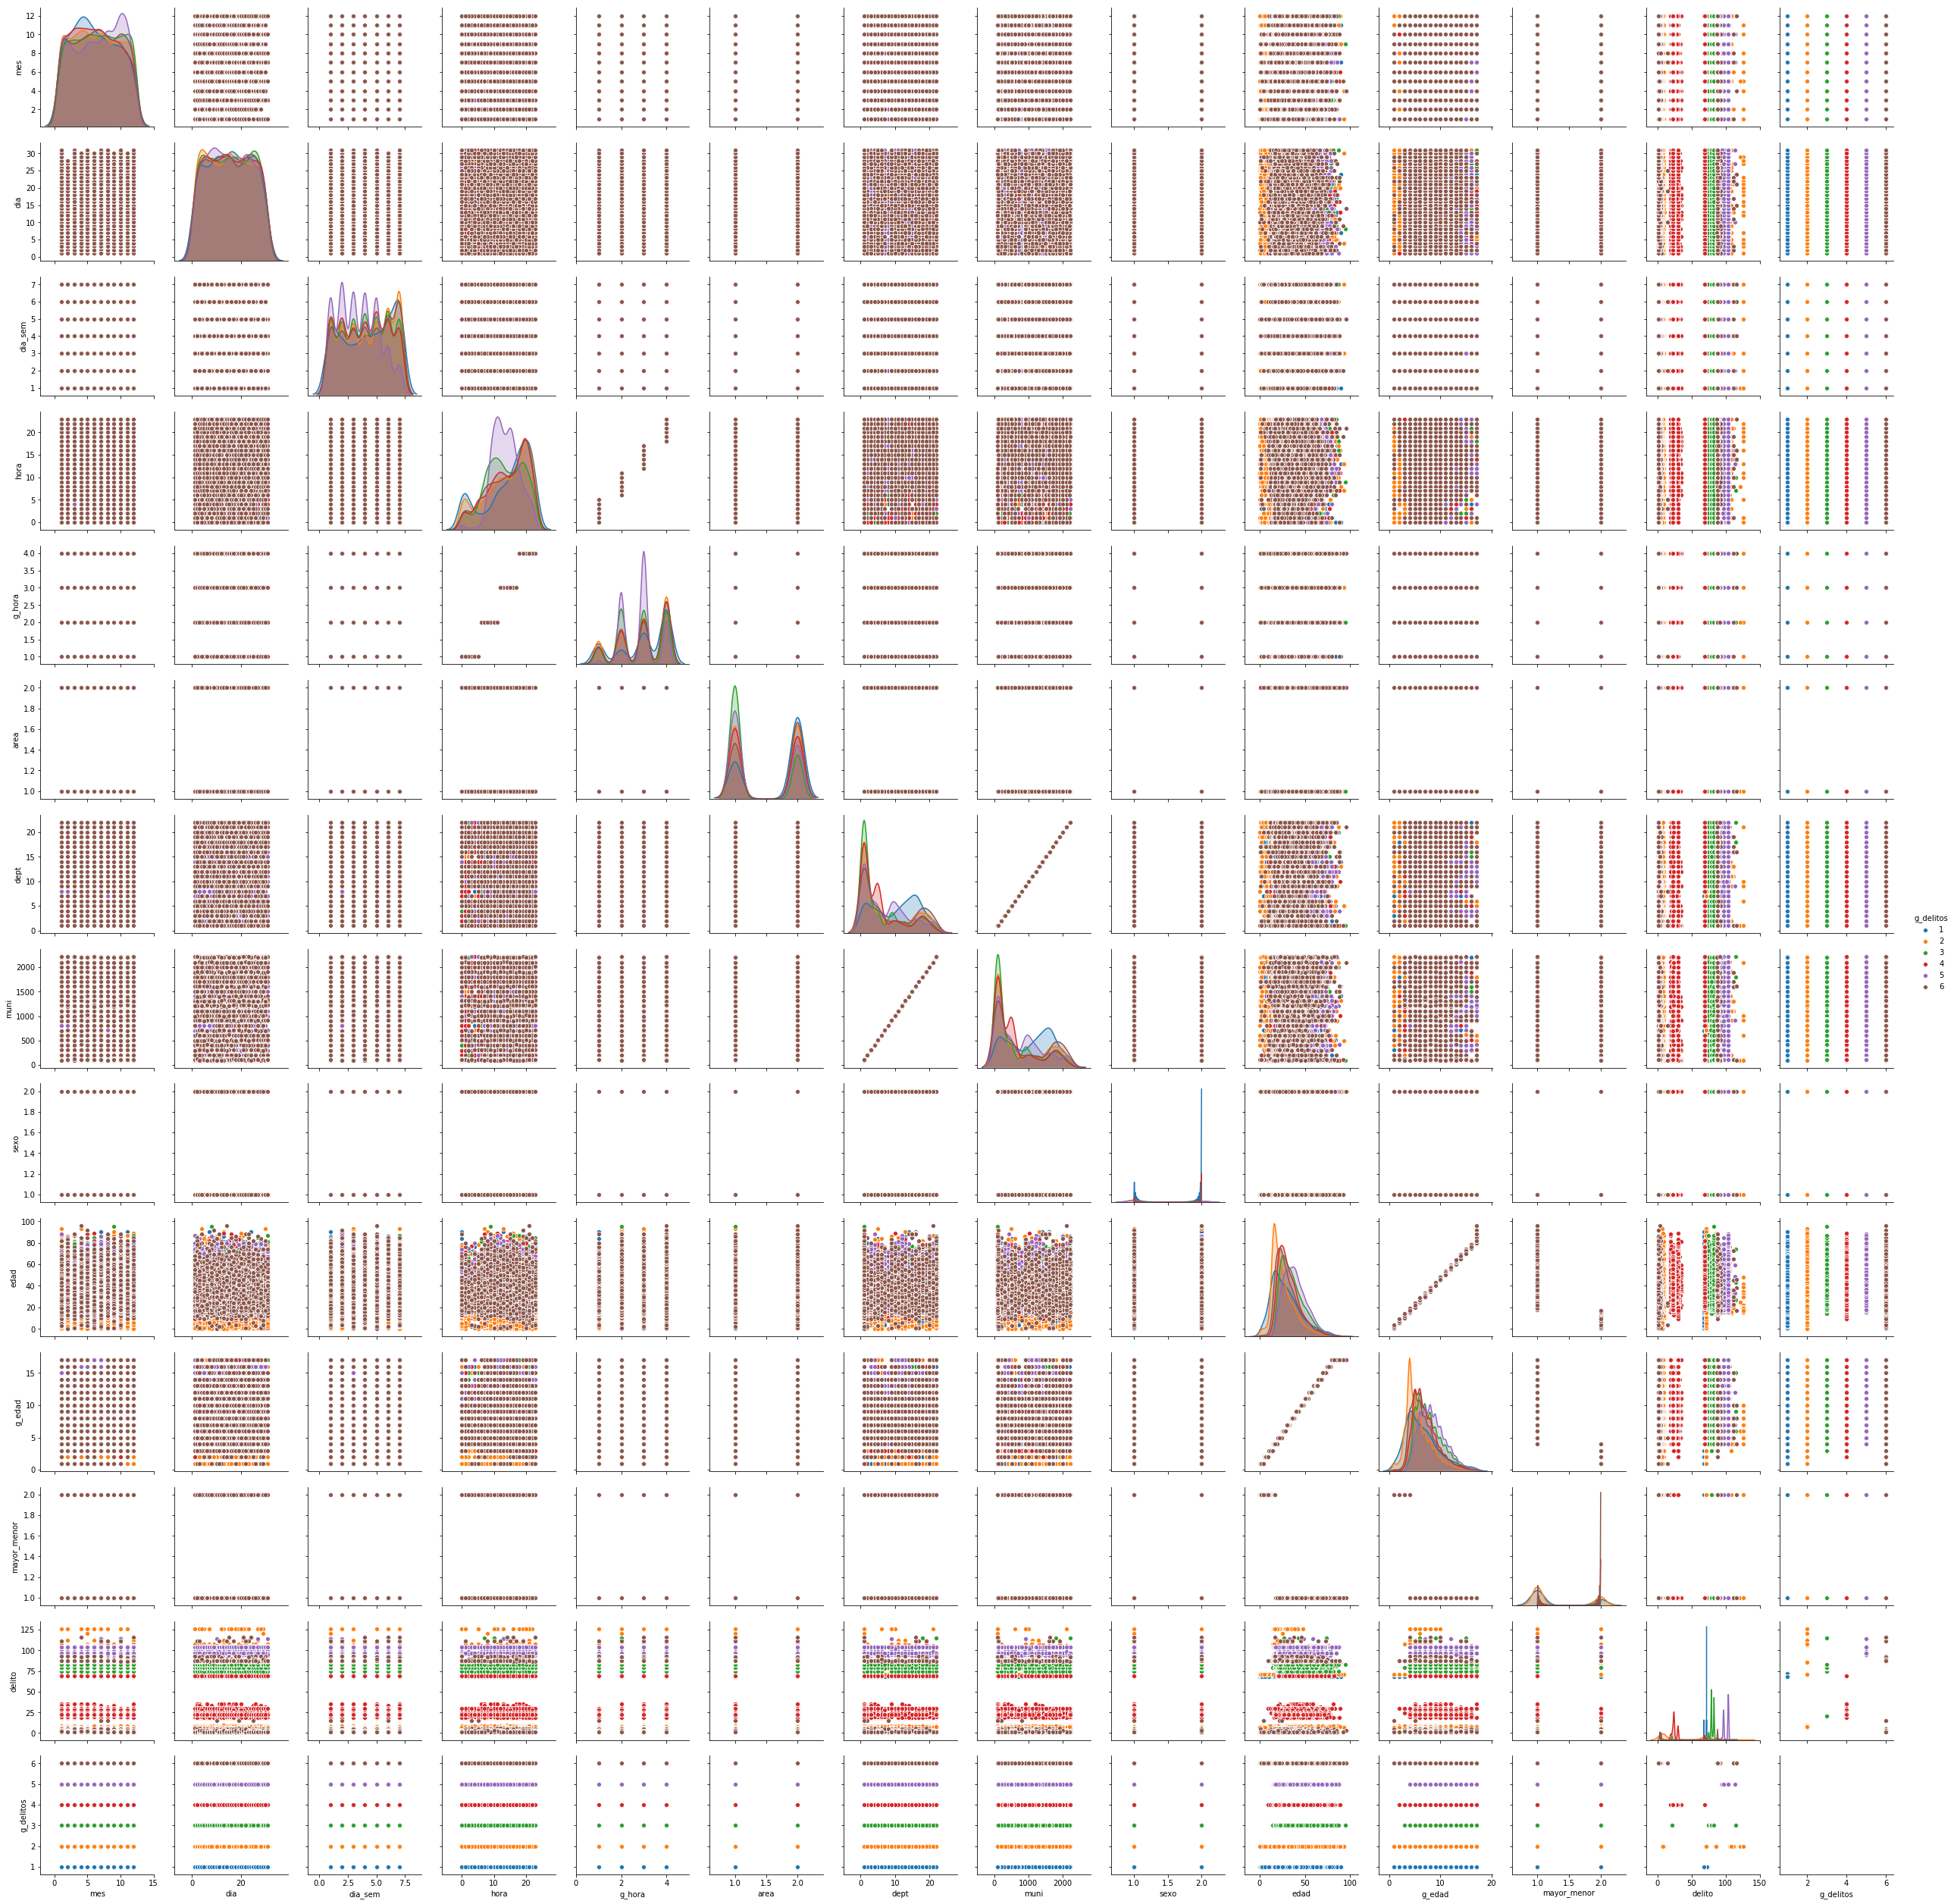

In [0]:
sns.pairplot(df, hue="g_delitos")

### Separación de datasets por categorías a analizar posteriormente

In [0]:
gua_city = df.loc[(df['dept'] == 1)] # dataset para ciudad de guatemala (mayores crimenes reportados)
gua_city.drop(u'dept', axis=1, inplace=True)# irrelevante
delito_com = df.loc[(df['delito'] == 104)]# mayor crimen reportado (y los valores de comparacion) crimen 104
delito_com.drop(u'delito', axis=1, inplace=True)# irrelevante
df_agrupa = df[[u'mes', u'dia_sem',u'g_hora',u'area',u'dept',u'sexo',u'g_edad', u'mayor_menor',u'g_delitos']] #dataset de agrupaciones
df_noagrupa = df[[u'mes', u'dia', u'hora', u'area', u'muni', u'sexo', u'edad', u'mayor_menor', u'delito']]#dataset sin agrupaciones


/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Anotaciones a considerar para conclusiones del analisis

## Preguntas a resolver en el procesamiento:

* El mes tiene relacion con la cantidad de delitos cometidos
* El mes tiene relacion con el tipo de delito cometido
* Los dias 1, 15 y 30 del mes tienen una cantidad mayor de delitos cometidos
* Prediccion: Grupo de delito
* Prediccion: Sexo de persona
* Prediccion: Grupo de edad
* Prediccion: Mayor o menor de edad

## Modelos a presentar en este reporte:

* Regresión logística
    * Simple
    * Multiple
* Análisis Discriminatorio Linear
* Análisis Discriminatorio Cuadratico
* K-Vecinos Cercanos
* Random Forest Classifier

**Usado dentro de las funciones para validar el grupo de testing y training**

- *Validacion cruzada de K iteraciones*
- *Matriz de confusion*

Otras funciones como:
* Regresion Linear
* Regresion Ridge
* Analisis de Componentes Principales

Fueron utilizados en un principio, pero por la naturaleza de la data no fueron eficientes en su desempeño por lo cual se decidieron quitar del análisis. Sin embargo, se encuentran en el Portafolio de algoritmos.

# Definición de funciones


### Función conjunta con todos los modelos de clasificacion

In [0]:
fct_names = ['Regresion Logistica', 'Analisis Discriminatorio Linear', 'Analisis Discriminatorio Cuadratico',
             'K vecinos Cercanos', 'Random Forest Classifier']

# X = todas las variables a evaluar
# Y = la variable independiente a evaluar
# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest
# El máximo de los componentes evaluados es la cantidad de features (x) evaluadas dentro del modelo

def fct_class(x, y, n, mf):
  resultados = []
  X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(x, y, test_size = 0.45, random_state = 42)
  
  
  # Regresion Logistica
  logisticRegr = LogisticRegression()
  logisticRegr.fit(X_train, Y_train)
  resultados.append(logisticRegr.score(X_test, Y_test))

  #Analisis Discriminatorio Linear
  LDA = LinearDiscriminantAnalysis(n_components=i)
  sc = StandardScaler()  
  X_train = sc.fit_transform(X_train)  
  X_test = sc.transform(X_test)
  LDA.fit(X_train, Y_train)
  resultados.append(LDA.score(X_test, Y_test))
  
  #Analisis Discriminatorio Cuadratico
  qda = QuadraticDiscriminantAnalysis()
  qda.fit(X_train, Y_train)
  resultados.append(qda.score(X_test, Y_test))


  # K Vecinos cercanos
  knn = KNeighborsClassifier(n_neighbors=n)  
  knn.fit(X_train, Y_train)  
  resultados.append(knn.score(X_test, Y_test))
  
  # Random Forest Classifier
  rfr = RandomForestClassifier(max_features=mf, random_state=42)
  rfr.fit(X_train, Y_train)
  resultados.append(rfr.score(X_test, Y_test))


  resultados_finales = {'Modelo' : fct_names, 'Score/Resultado' : resultados}
  
  tabla_final = pd.DataFrame(resultados_finales)
  print("")
  return(tabla_final)

### Regresión lineal (simple o múltiple)

In [0]:
def regresion_lineal(x, y):
  X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(x, y, test_size = 0.3, random_state = 42)
  lm = LinearRegression()
  lm = lm.fit(X_train, Y_train)
  pred_train = lm.predict(X_train)
  pred_test = lm.predict(X_test)
  print("Regresion Linear con X_train, MSE con Y_train: %0.5f" % (np.mean((Y_train - lm.predict(X_train)) ** 2)))
  print("Regresion Linear con X_test, MSE con Y_test:   %0.5f" % (np.mean((Y_test - lm.predict(X_test)) ** 2)))
  scores = cross_val_score(lm, x, y, cv=5)
  print("Regresion Linear Calculated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  print("Regresion Linear Model score: %0.2f" % (lm.score(X_test, Y_test)))

### Regresión logística

In [0]:
def regresion_logistica(x,y):
  logisticRegr = LogisticRegression()
  X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(x, y, test_size = 0.3, random_state = 42)
  logisticRegr.fit(X_train, Y_train)
  predictions = logisticRegr.predict(X_test)
  score = logisticRegr.score(X_test, Y_test)
  print("")
  print("Score de la regresion logistica: %0.5f" % score)
  cm = metrics.confusion_matrix(Y_test, predictions)
  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {0}'.format(score)
  plt.title(all_sample_title, size = 15);

### Análisis Discriminatorio Lineal (LDA)

In [0]:
def lda_analysis(x, y,i):
  LDA = LinearDiscriminantAnalysis(n_components=i)
  X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(x, y, test_size = 0.3, random_state = 42)
  sc = StandardScaler()  
  X_train = sc.fit_transform(X_train)  
  X_test = sc.transform(X_test)
  
  LDA.fit(X_train, Y_train)
  predictions = LDA.predict(X_test)
  score = LDA.score(X_test, Y_test)
  print("")
  print("Score del modelo LDA es: %0.2f" % score)
  cm = metrics.confusion_matrix(Y_test, predictions)
  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {0}'.format(score)
  plt.title(all_sample_title, size = 15);

### Análisis del Componente Principal (PCA)



In [0]:
PC_list = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20']
def pca_analysis(x, y, i):
  pca = PCA(n_components=i)

  X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(x, y, test_size = 0.3, random_state = 42)
  sc = StandardScaler()  
  X_train = sc.fit_transform(X_train)  
  X_test = sc.transform(X_test)
  
  pca.fit(X_train, Y_train)
  score = pca.score(X_test, Y_test)
  print("")
  print("Score del modelo PCA es: %0.3f" % score)
  print("")
  
  pca_df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':PC_list[0:i]})
  
  sns.barplot(x='PC',y="var", 
           data=pca_df, color="c")

### K-Vecinos Cercanos (KNN) y gráficas de performance en un rango de valores

In [0]:
def knearest(x, y, i):
  X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(x, y, test_size = 0.3, random_state = 42)
  knn = KNeighborsClassifier(n_neighbors=i)  
  knn.fit(X_train, Y_train)  
  print("Model score: %0.2f" % (knn.score(X_test, Y_test)))
  return knn.score(X_test, Y_test)

def knearestgraph(x, y, i):
  X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(x, y, test_size = 0.3, random_state = 42)
  knn = KNeighborsClassifier(n_neighbors=i)  
  knn.fit(X_train, Y_train)  
  return knn.score(X_test, Y_test)

def function1(x, y, i):
  return knearestgraph(x,y,i)

def graphknn(x, y, t, l):
  for i in range(len(t)):
    l[i] = function1(x, y, t[i])

  plot(t, l)
  show()

### Regresión Ridge


In [0]:
def ridge_regr_w_lr(x, y):
  X_train,X_test,y_train,y_test=train_test_split(x, y, test_size=0.3,random_state=42)

  # Linear Regression
  lr = LinearRegression()
  lr.fit(X_train, y_train)

  train_score=lr.score(X_train, y_train)
  test_score=lr.score(X_test, y_test)

  print "Linear Regression train score:", train_score
  print "Linear Regression test score: ", test_score


  #Ridge Regression de 0.01
  rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely restricted and in this case linear and ridge regression resembles
  rr.fit(X_train, y_train)

  Ridge_train_score = rr.score(X_train,y_train)
  Ridge_test_score = rr.score(X_test, y_test)

  print ""
  print "Ridge Regression train score low alpha:", Ridge_train_score
  print "Ridge Regression test score low alpha: ", Ridge_test_score


  #Ridge Regression de 100
  rr100 = Ridge(alpha=100) # comparison with alpha value
  rr100.fit(X_train, y_train)

  Ridge_train_score100 = rr100.score(X_train,y_train)
  Ridge_test_score100 = rr100.score(X_test, y_test)

  print ""
  print "Ridge Regression train score high alpha:", Ridge_train_score100
  print "Ridge Regression test score high alpha: ", Ridge_test_score100
  print ""

  #Plotting the graph
  plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
  plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') # alpha here is for transparency
  plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
  plt.xlabel('Coefficient Index',fontsize=16)
  plt.ylabel('Coefficient Magnitude',fontsize=16)
  plt.legend(fontsize=13,loc=4)
  plt.show()


### Análisis Discriminatorio Cuadrático (QDA)

In [0]:
def qda_analysis(x, y):
  X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(x, y, test_size = 0.3, random_state = 42)
  qda = QuadraticDiscriminantAnalysis()
  y_pred = qda.fit(X_train, Y_train).predict(X_test)
  score = qda.score(X_test, Y_test)
  print("El score del modelo QDA es: %0.2f" % score)

### Funcion de Random Forest Feature Importance

In [0]:
def random_forest_graph(x, y, mf):
  X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(x, y, test_size = 0.3, random_state = 42)
  rfc = RandomForestClassifier(max_features=mf, random_state=42)
  rfc.fit(X_train, Y_train)
  Importance = pd.DataFrame({'Importance':rfc.feature_importances_*100/rfc.feature_importances_.max()}, index=x)
  Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
  plt.xlabel('Variable Importance')
  plt.gca().legend_ = None

### Funcion de Gradient Boosting Graph de Feature Importance

In [0]:
def gradient_boosting(x, y, ne, lr):
  X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(x, y, test_size = 0.3, random_state = 42)
  regr = GradientBoostingClassifier(n_estimators=ne, learning_rate=lr, random_state=42)
  regr.fit(X_train, Y_train)
  feature_importance = regr.feature_importances_*100
  rel_imp = pd.Series(feature_importance/regr.feature_importances_.max(), index=x).sort_values(inplace=False)
  rel_imp.T.plot(kind='barh', color='r')
  plt.xlabel('Variable Importance')
  plt.gca().legend_ = None

# Testeo del modelaje de datos en diferentes conjuntos del conjunto de datos generales

### Predicción del grupo de delito a partir del delito
* para ejemplificar el resultado ideal

In [0]:
x = df[[u'g_delitos']]
y = df[u'g_delitos']

print("Prediccion del delito a partir del grupo de delitos")
print("")

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

fct_class(x, y, n, mf)

Prediccion del delito a partir del grupo de delitos



/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are col

,Modelo,Score/Resultado
0,Regresion Logistica,0.846239
1,Analisis Discriminatorio Linear,1.000000
2,Analisis Discriminatorio Cuadratico,0.204877
3,K vecinos Cercanos,1.000000
4,Random Forest Classifier,1.000000


### Grupo de edad para predecir el grupo de Delitos

In [0]:
x = df[[u'g_edad']]
y = df[u'g_delitos']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

fct_class(x, y, n, mf)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.307178
1,Analisis Discriminatorio Linear,0.307178
2,Analisis Discriminatorio Cuadratico,0.307178
3,K vecinos Cercanos,0.281689
4,Random Forest Classifier,0.325778


### Predicción de grupos de delitos a partir del departamento

In [0]:
x = df[[u'dept']]
y = df[u'g_delitos']


# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

fct_class(x, y, n, mf)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.256545
1,Analisis Discriminatorio Linear,0.256545
2,Analisis Discriminatorio Cuadratico,0.239873
3,K vecinos Cercanos,0.253238
4,Random Forest Classifier,0.304009


### Predicción de grupos de delitos a partir de la edad

In [0]:
x = df[[u'edad']]
y = df[u'g_delitos']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

fct_class(x, y, n, mf)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.310416
1,Analisis Discriminatorio Linear,0.309314
2,Analisis Discriminatorio Cuadratico,0.312483
3,K vecinos Cercanos,0.251033
4,Random Forest Classifier,0.327776


### Predicción si la persona es mayor o menor de edad a partir del grupo de delitos (FG)



Prediccion si la persona es mayor o menor de edad a partir del grupo de delitos



/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.



                                Modelo  Score/Resultado
0                  Regresion Logistica         0.878548
1      Analisis Discriminatorio Linear         0.878548
2  Analisis Discriminatorio Cuadratico         0.878548
3                   K vecinos Cercanos         0.878548
4             Random Forest Classifier         0.878548

Score de la regresion logistica: 0.87849


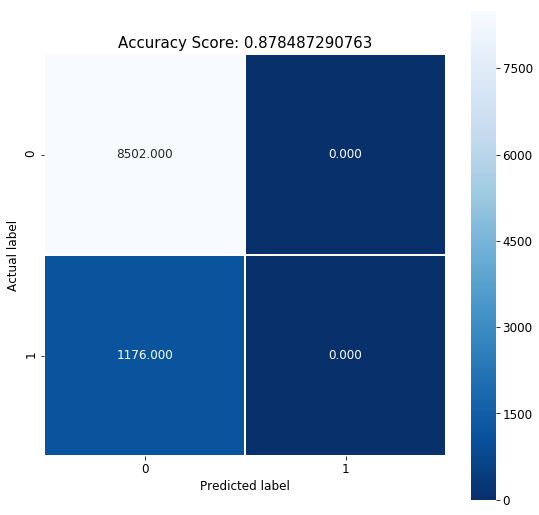

In [0]:
x = df[[u'g_delitos']]
y = df[u'mayor_menor']

print("Prediccion si la persona es mayor o menor de edad a partir del grupo de delitos")
print("")

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

print(fct_class(x, y, n, mf))

regresion_logistica(x,y)

### Predicción del delito a partir del sexo de la persona

In [0]:
x = df[[u'sexo']]
y = df[u'g_delitos']

print("Prediccion del delito a partir del sexo de la persona")
print("")

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

fct_class(x, y, n, mf)

Prediccion del delito a partir del sexo de la persona



/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.257647
1,Analisis Discriminatorio Linear,0.257647
2,Analisis Discriminatorio Cuadratico,0.257647
3,K vecinos Cercanos,0.208804
4,Random Forest Classifier,0.257647


### Predicción de la edad a partir del dia de la semana

In [0]:
x = df[[u'dia_sem']]
y = df[u'g_edad']

print("Prediccion de la edad a partir del dia de la semana")
print("")

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

fct_class(x, y, n, mf)

Prediccion de la edad a partir del dia de la semana



/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.159548
1,Analisis Discriminatorio Linear,0.159548
2,Analisis Discriminatorio Cuadratico,0.161201
3,K vecinos Cercanos,0.114908
4,Random Forest Classifier,0.152384


### Predicción del mes a partir del grupo de delitos

In [0]:
x = df[[u'g_delitos']]
y = df[u'mes']

print("Prediccion del mes a partir del dia del grupo de delitos")
print("")

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

fct_class(x, y, n, mf)

Prediccion del mes a partir del dia del grupo de delitos



/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.091485
1,Analisis Discriminatorio Linear,0.091485
2,Analisis Discriminatorio Cuadratico,0.091141
3,K vecinos Cercanos,0.083287
4,Random Forest Classifier,0.093552


### Predicción de mayor o menor de edad a partir del delito (FG)

Predicción si la persona es mayor o menor de edad a partir del delito



/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.



                                Modelo  Score/Resultado
0                  Regresion Logistica         0.878548
1      Analisis Discriminatorio Linear         0.878548
2  Analisis Discriminatorio Cuadratico         0.878548
3                   K vecinos Cercanos         0.908239
4             Random Forest Classifier         0.908239

Score de la regresion logistica: 0.87849


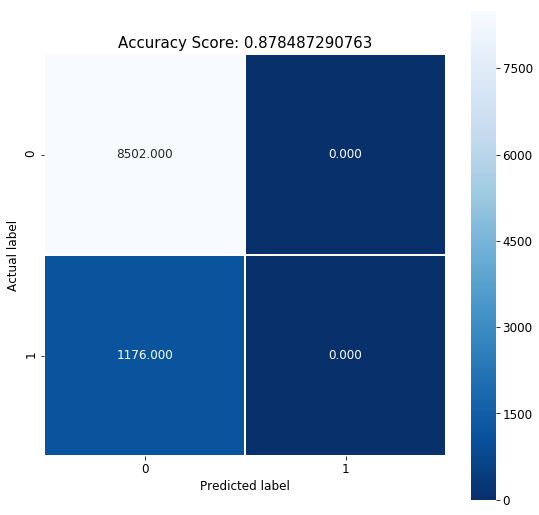

In [0]:
x = df[[u'delito']]
y = df[u'mayor_menor']

print("Predicción si la persona es mayor o menor de edad a partir del delito")
print("")

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

print(fct_class(x, y, n, mf))

regresion_logistica(x,y)

### Predicción del mes

In [0]:
x = df[[u'g_hora', u'area',
       u'muni', u'sexo', u'g_edad', u'g_delitos']]
y = df[u'mes']

print("Prediccion del mes")
print("")

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 4      # maximo el numero de x

fct_class(x, y, n, mf)

Prediccion del mes



/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.092725
1,Analisis Discriminatorio Linear,0.093070
2,Analisis Discriminatorio Cuadratico,0.093621
3,K vecinos Cercanos,0.100372
4,Random Forest Classifier,0.112772


### Predicción del departamento

In [0]:
x = df[[u'dia_sem', u'hora', u'area', u'sexo',  u'g_edad', u'mayor_menor', u'delito']]
y = df[u'dept']

print("Prediccion del departamento")
print("")

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 7      # maximo el numero de x

fct_class(x, y, n, mf)

Prediccion del departamento



/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.410995
1,Analisis Discriminatorio Linear,0.418917
2,Analisis Discriminatorio Cuadratico,0.417470
3,K vecinos Cercanos,0.394599
4,Random Forest Classifier,0.360154


### Predicción del grupo de edad

In [0]:
x = df[[u'mes', u'dia_sem', u'g_hora', u'area', u'dept', u'sexo', u'delito']]
y = df[u'g_edad']

print("Prediccion del grupo de edad")
print("")

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 3
mf = 7      # maximo el numero de x

fct_class(x, y, n, mf)

Prediccion del grupo de edad



/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.188068
1,Analisis Discriminatorio Linear,0.188826
2,Analisis Discriminatorio Cuadratico,0.190617
3,K vecinos Cercanos,0.160719
4,Random Forest Classifier,0.163199


### Predicción del grupo de delito


In [0]:
x = df[[u'mes', u'dia', u'dia_sem', u'hora', u'area', u'dept',
       u'muni', u'sexo', u'edad', u'mayor_menor']]
y = df[u'g_delitos']

print("Predicción del grupo de delito")
print("")

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 2      # maximo el numero de x

fct_class(x, y, n, mf)

Predicción del grupo de delito



/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.368421
1,Analisis Discriminatorio Linear,0.360637
2,Analisis Discriminatorio Cuadratico,0.352990
3,K vecinos Cercanos,0.356434
4,Random Forest Classifier,0.410306


### Prediccion del sexo de la persona que cometió el crimen (FG)

Regresión logistica del sexo de la persona


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.



                                Modelo  Score/Resultado
0                  Regresion Logistica         0.759782
1      Analisis Discriminatorio Linear         0.756407
2  Analisis Discriminatorio Cuadratico         0.744213
3                   K vecinos Cercanos         0.740769
4             Random Forest Classifier         0.758336

Score de la regresion logistica: 0.75873


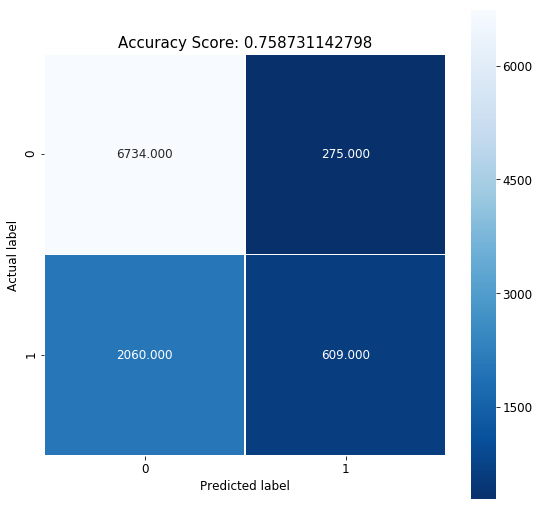

In [0]:
x = df[[u'mes', u'dia', u'dia_sem', u'hora', u'area', u'dept',
       u'muni', u'edad', u'mayor_menor', u'delito']]
y = df[u'sexo']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

print(fct_class(x, y, n, mf))

regresion_logistica(x,y)

### Predicción de la persona mayor o menor de edad (FG) 

Regresión logistica de la persona mayor o menor de edad


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.



                                Modelo  Score/Resultado
0                  Regresion Logistica         0.878548
1      Analisis Discriminatorio Linear         0.878548
2  Analisis Discriminatorio Cuadratico         0.878548
3                   K vecinos Cercanos         0.880477
4             Random Forest Classifier         0.894392

Score de la regresion logistica: 0.87849


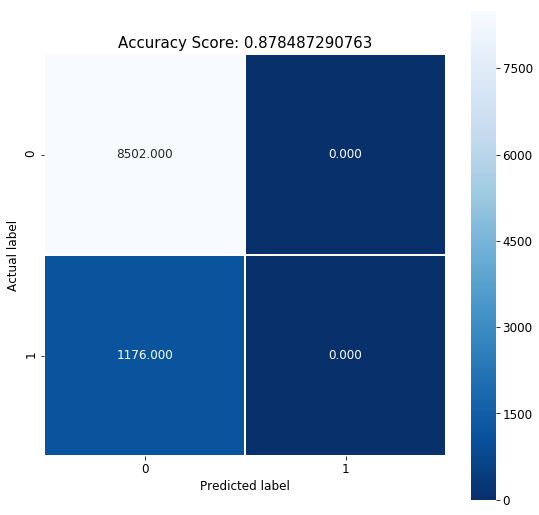

In [0]:
x = df[[u'mes', u'dia', u'dia_sem', u'hora', u'area',
       u'muni', u'sexo', u'delito']]
y = df[u'mayor_menor']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

print(fct_class(x, y, n, mf))

regresion_logistica(x,y)

* Nunca predijo que fuera menor de edad pero por tener muchos mas datos de personas mayores de edad tiene un puntaje de accuracy alto.


### Predicción de grupo de hora (FG)

Regresión logistica del grupo de hora


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.



                                Modelo  Score/Resultado
0                  Regresion Logistica         0.394324
1      Analisis Discriminatorio Linear         0.394599
2  Analisis Discriminatorio Cuadratico         0.397010
3                   K vecinos Cercanos         0.336594
4             Random Forest Classifier         0.384197

Score de la regresion logistica: 0.39192


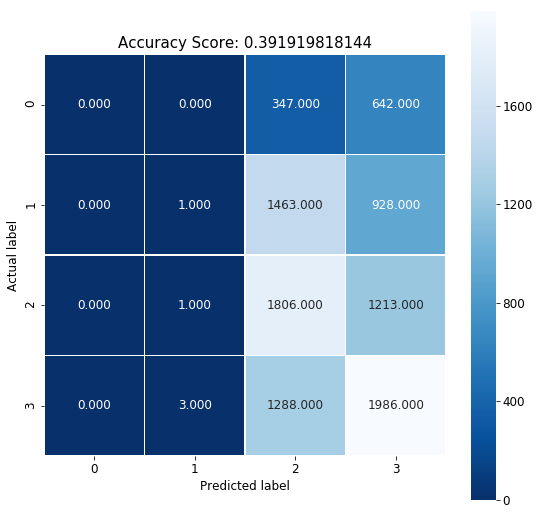

In [0]:
x = df[[u'mes', u'dia', u'dia_sem', u'area', u'dept',
       u'muni', u'sexo', u'edad', u'delito']]
y = df[u'g_hora']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 5      # maximo el numero de x

print(fct_class(x, y, n, mf))

regresion_logistica(x,y)

In [0]:
x = df[[u'mes', u'dia', u'dia_sem', u'hora', u'area', u'dept',
       u'muni', u'sexo', u'g_edad', u'mayor_menor']]
y = df[u'g_delitos']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 10      # maximo el numero de x

fct_class(x, y, n, mf)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.368766
1,Analisis Discriminatorio Linear,0.360154
2,Analisis Discriminatorio Cuadratico,0.352508
3,K vecinos Cercanos,0.355539
4,Random Forest Classifier,0.406448


### Prediccion de grupo delito (FG)

Regresión logistica del grupo de delito


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.



                                Modelo  Score/Resultado
0                  Regresion Logistica         0.368766
1      Analisis Discriminatorio Linear         0.360154
2  Analisis Discriminatorio Cuadratico         0.352508
3                   K vecinos Cercanos         0.355539
4             Random Forest Classifier         0.410375

Score de la regresion logistica: 0.36319


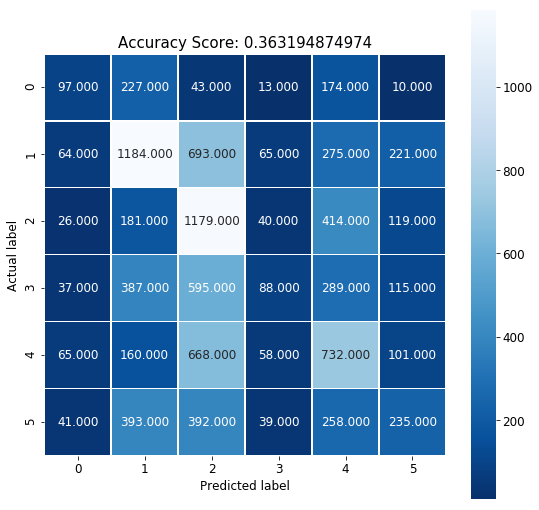

In [0]:
x = df[[u'mes', u'dia', u'dia_sem', u'hora', u'area', u'dept',
       u'muni', u'sexo', u'g_edad', u'mayor_menor']]
y = df[u'g_delitos']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 5      # maximo el numero de x

print(fct_class(x, y, n, mf))

regresion_logistica(x,y)

# Testeo del modelaje de datos en diferentes conjuntos del conjunto de la Ciudad de Guatemala

### General plotting Guatemala city

/usr/local/lib/python2.7/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python2.7/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python2.7/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


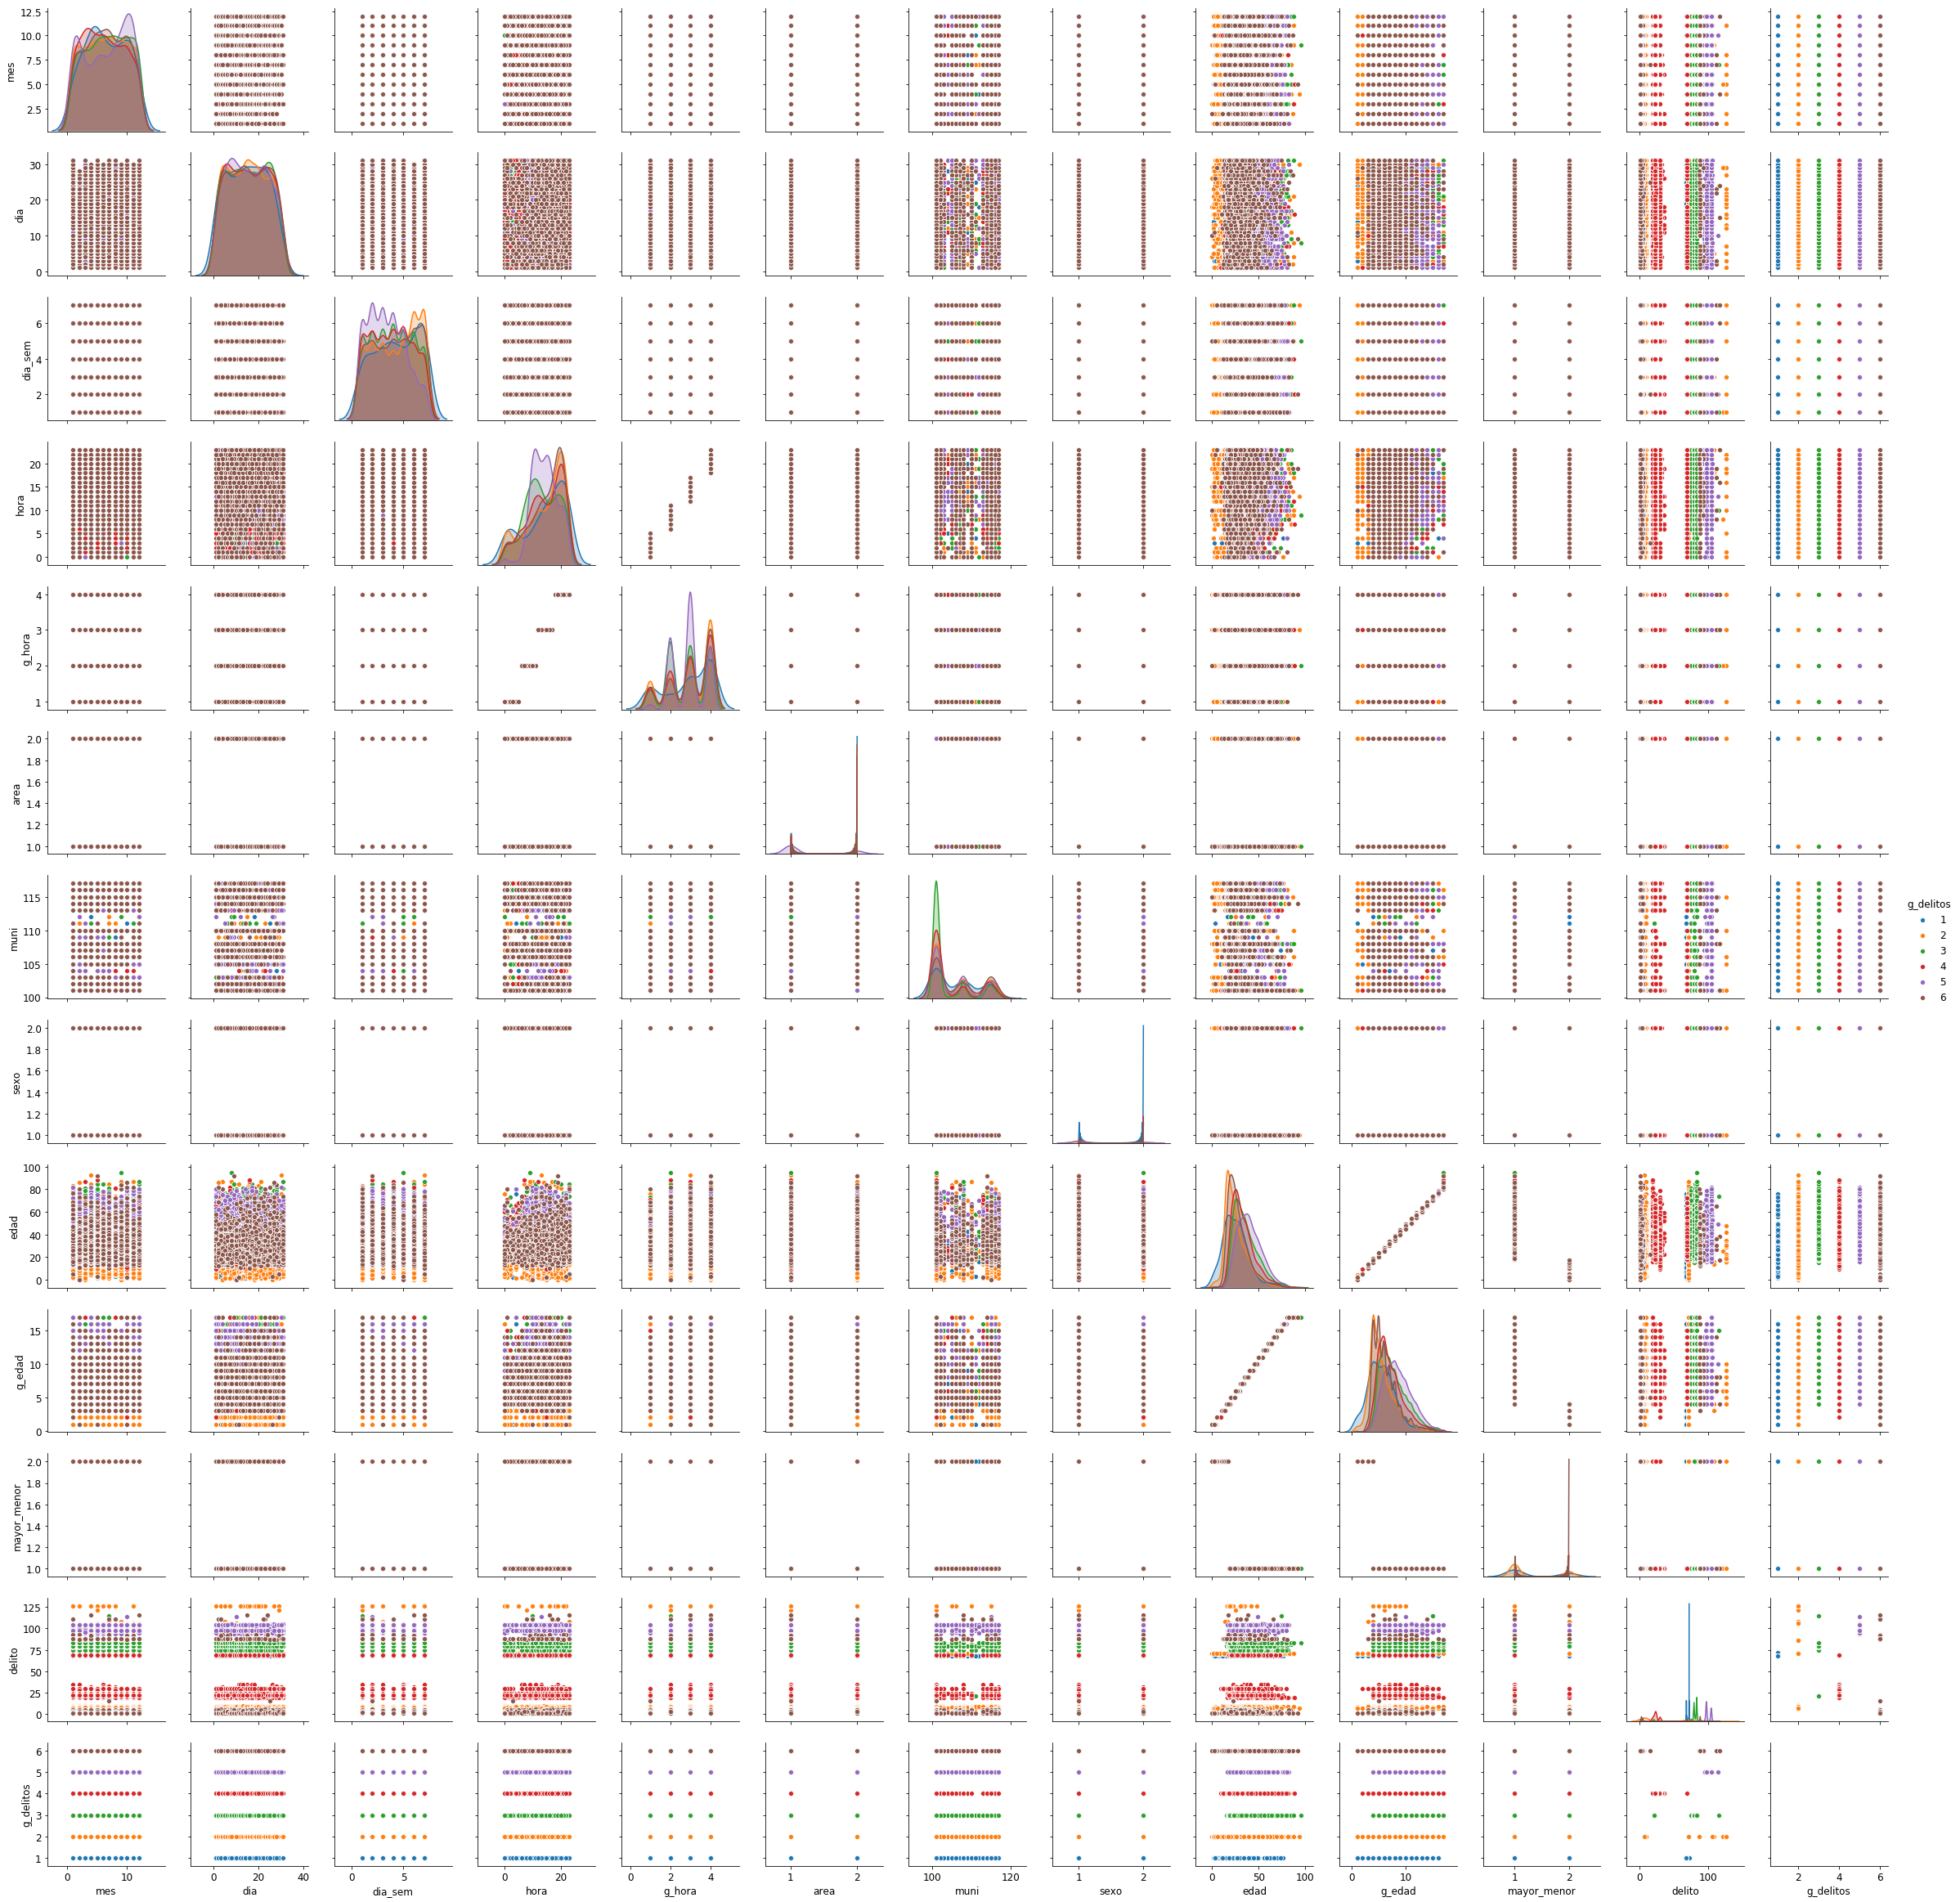

In [0]:
sns.pairplot(gua_city, hue="g_delitos")

### Prediccion del grupo de delitos por mes

In [0]:
x = gua_city[[u'mes']]
y = gua_city[u'g_delitos']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

fct_class(x, y, n, mf)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.282249
1,Analisis Discriminatorio Linear,0.282249
2,Analisis Discriminatorio Cuadratico,0.280610
3,K vecinos Cercanos,0.216194
4,Random Forest Classifier,0.280118


### Prediccion del grupo de delitos (FG)

In [0]:
x = gua_city[[u'mes', u'dia', u'dia_sem', u'hora', u'area',
       u'muni', u'sexo', u'g_edad', u'mayor_menor']]
y = gua_city[u'g_delitos']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

fct_class(x, y, n, mf)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.404852
1,Analisis Discriminatorio Linear,0.405507
2,Analisis Discriminatorio Cuadratico,0.386986
3,K vecinos Cercanos,0.371906
4,Random Forest Classifier,0.407146


### Prediccion del grupo de delito

In [0]:
x = gua_city[[u'mes', u'dia', u'dia_sem', u'hora', u'area', u'sexo', u'g_edad', u'mayor_menor']]
y = gua_city[u'g_delitos']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

fct_class(x, y, n, mf)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.402229
1,Analisis Discriminatorio Linear,0.399607
2,Analisis Discriminatorio Cuadratico,0.376168
3,K vecinos Cercanos,0.356007
4,Random Forest Classifier,0.378299


### Prediccion del mes

In [0]:
x = gua_city[[u'delito', u'dia', u'dia_sem', u'hora', u'area', 
       u'muni', u'sexo', u'g_edad', u'mayor_menor']]
y = gua_city[u'mes']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 1      # maximo el numero de x

fct_class(x, y, n, mf)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.098017
1,Analisis Discriminatorio Linear,0.095722
2,Analisis Discriminatorio Cuadratico,0.101623
3,K vecinos Cercanos,0.126373
4,Random Forest Classifier,0.205704


### Prediccion de sexo (FG)

In [0]:
x = gua_city[[u'mes', u'dia', u'dia_sem', u'hora', u'area', 
       u'muni', u'delito', u'g_edad', u'mayor_menor']]
y = gua_city[u'sexo']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 8      # maximo el numero de x

fct_class(x, y, n, mf)


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.787084
1,Analisis Discriminatorio Linear,0.786101
2,Analisis Discriminatorio Cuadratico,0.762498
3,K vecinos Cercanos,0.765448
4,Random Forest Classifier,0.777250


### Prediccion del grupo de edad

In [0]:
x = gua_city[[u'mes', u'dia', u'dia_sem', u'hora', u'area', 
       u'muni', u'delito', u'sexo', u'mayor_menor']]
y = gua_city[u'g_edad']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 4
mf = 8      # maximo el numero de x

fct_class(x, y, n, mf)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are col

,Modelo,Score/Resultado
0,Regresion Logistica,0.259138
1,Analisis Discriminatorio Linear,0.213408
2,Analisis Discriminatorio Cuadratico,0.028520
3,K vecinos Cercanos,0.201934
4,Random Forest Classifier,0.228487


### Prediccion del dia de la semana 

In [0]:
x = gua_city[[u'mes', u'hora', u'area', u'g_edad',
        u'g_delitos', u'sexo', u'mayor_menor']]
y = gua_city[u'dia_sem']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 9
mf = 2      # maximo el numero de x

fct_class(x, y, n, mf)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.164071
1,Analisis Discriminatorio Linear,0.162760
2,Analisis Discriminatorio Cuadratico,0.167350
3,K vecinos Cercanos,0.162268
4,Random Forest Classifier,0.177348


### Prediccion de mayor o menor de edad (FG)


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.



                                Modelo  Score/Resultado
0                  Regresion Logistica         0.947713
1      Analisis Discriminatorio Linear         0.932306
2  Analisis Discriminatorio Cuadratico         0.930011
3                   K vecinos Cercanos         0.942468
4             Random Forest Classifier         0.951319

Score de la regresion logistica: 0.94935


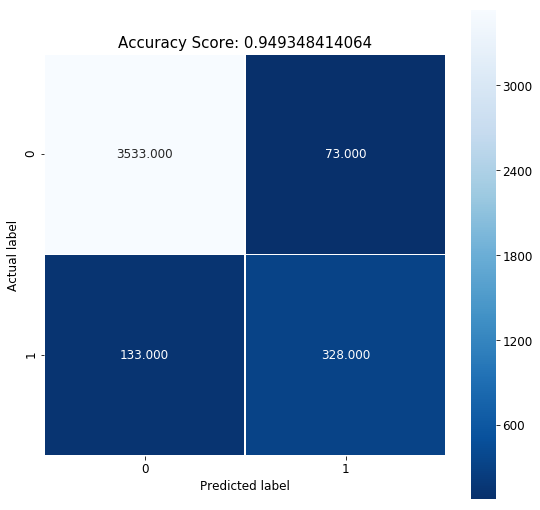

In [0]:
x = gua_city[[u'mes',  u'dia_sem', u'hora', u'area', u'g_edad',
        u'g_delitos', u'sexo',]]
y = gua_city[u'mayor_menor']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 9
mf = 2      # maximo el numero de x

print(fct_class(x, y, n, mf))

regresion_logistica(x,y)

### Prediccion del grupo de hora (FG)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.



                                Modelo  Score/Resultado
0                  Regresion Logistica         0.386986
1      Analisis Discriminatorio Linear         0.387805
2  Analisis Discriminatorio Cuadratico         0.369775
3                   K vecinos Cercanos         0.351746
4             Random Forest Classifier         0.355352

Score de la regresion logistica: 0.38849


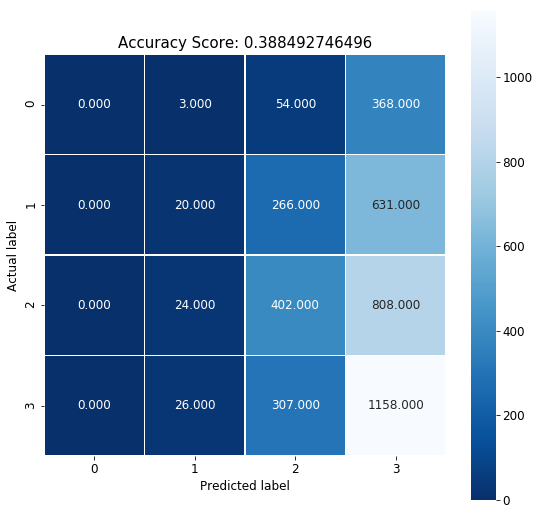

In [0]:
x = gua_city[[u'mes', u'dia', u'dia_sem', u'mayor_menor', u'area', u'g_edad',
        u'g_delitos', u'sexo']]
y = gua_city[u'g_hora']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 9
mf = 2      # maximo el numero de x

print(fct_class(x, y, n, mf))

regresion_logistica(x,y)

### Prediccion del dia de la semana

In [0]:
x = gua_city[[u'mes', u'dia', u'mayor_menor', u'hora', u'area', u'g_edad',
        u'delito', u'sexo']]
y = gua_city[u'dia_sem']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 3
mf = 2      # maximo el numero de x

fct_class(x, y, n, mf)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,Modelo,Score/Resultado
0,Regresion Logistica,0.182101
1,Analisis Discriminatorio Linear,0.181773
2,Analisis Discriminatorio Cuadratico,0.170464
3,K vecinos Cercanos,0.187346
4,Random Forest Classifier,0.302082


### Prediccion de grupo de delitos por municipalidad

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.



                                Modelo  Score/Resultado
0                  Regresion Logistica         0.330765
1      Analisis Discriminatorio Linear         0.330765
2  Analisis Discriminatorio Cuadratico         0.327651
3                   K vecinos Cercanos         0.273234
4             Random Forest Classifier         0.336502

Score de la regresion logistica: 0.33046


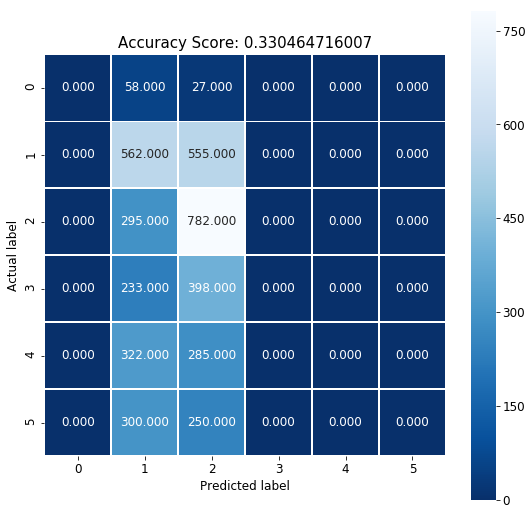

In [0]:
x = gua_city[['muni']]
y = gua_city[u'g_delitos']

# n = numero de vecinos cercanos a evaluar
# mf = max features en el modelo de random forest

n = 1
mf = 1      # maximo el numero de x

print(fct_class(x, y, n, mf))

regresion_logistica(x,y)